<a href="https://colab.research.google.com/github/southeastwind13/deep_learning/blob/main/7_CNN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11025058.56it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173820.64it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3160819.28it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6437768.93it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor())

In [ ]:
# Number of classes
K = len(set(train_dataset.targets.numpy()))
print(f"Number of classes: {K}")

Number of classes: 10


In [ ]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU()
    )

    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features=128 * 2 * 2, out_features=512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=512, out_features=K)
    )

  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1) # Flatten
    out = self.dense_layers(out)
    return out

# Please readmore
# 1. Convolution arithmetic (https://arxiv.org/pdf/1603.07285)
# 2. https://pytorch.org/docs/stable/nn.html

In [ ]:
# Instantiate the model
model = CNN(K)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Data Loader
# Useful because it automatically generates batches in the training loop and takes care of shuffling.

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False)

In [ ]:
# A function to encapsulate the training loop.

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for iteration in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []

    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[iteration] = train_loss
    test_losses[iteration] = test_loss

    dt = datetime.now() - t0
    print(f"Epoch {iteration+1}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Duration: {dt}")

  return train_losses, test_losses




In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15 | Train Loss: 0.6517 | Test Loss: 0.4791 | Duration: 0:00:11.347142
Epoch 2/15 | Train Loss: 0.4352 | Test Loss: 0.4192 | Duration: 0:00:09.750668
Epoch 3/15 | Train Loss: 0.3785 | Test Loss: 0.3710 | Duration: 0:00:10.249776
Epoch 4/15 | Train Loss: 0.3424 | Test Loss: 0.3408 | Duration: 0:00:09.979835
Epoch 5/15 | Train Loss: 0.3152 | Test Loss: 0.3312 | Duration: 0:00:09.745234
Epoch 6/15 | Train Loss: 0.2964 | Test Loss: 0.3270 | Duration: 0:00:09.824658
Epoch 7/15 | Train Loss: 0.2757 | Test Loss: 0.2963 | Duration: 0:00:09.888927
Epoch 8/15 | Train Loss: 0.2579 | Test Loss: 0.2971 | Duration: 0:00:09.798768
Epoch 9/15 | Train Loss: 0.2431 | Test Loss: 0.3022 | Duration: 0:00:09.624860
Epoch 10/15 | Train Loss: 0.2282 | Test Loss: 0.2898 | Duration: 0:00:09.776056
Epoch 11/15 | Train Loss: 0.2168 | Test Loss: 0.2817 | Duration: 0:00:09.749158
Epoch 12/15 | Train Loss: 0.2014 | Test Loss: 0.2912 | Duration: 0:00:09.822980
Epoch 13/15 | Train Loss: 0.1911 | Test Loss: 0.2

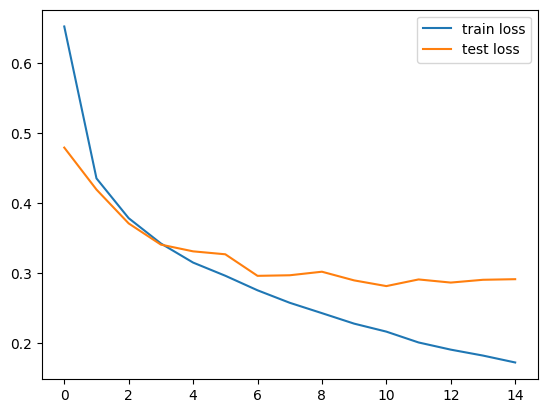

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

model.eval()
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}")
print(f"Test acc: {test_acc:.4f}")

Train acc: 0.9539
Test acc: 0.9005


In [ ]:
# Confusion matrix
from types import FrameType
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[881   0  17  16   1   1  80   0   4   0]
 [  0 978   1  13   3   0   3   0   2   0]
 [ 17   1 863   9  30   0  79   0   1   0]
 [ 16   3  15 900  32   0  32   0   2   0]
 [  1   1  76  25 784   0 110   0   3   0]
 [  0   0   0   2   0 972   0  16   1   9]
 [129   1  61  22  54   0 720   0  13   0]
 [  0   0   0   0   0  13   0 961   0  26]
 [  5   1   4   0   4   1   6   1 976   2]
 [  1   0   0   0   0   4   0  25   0 970]]


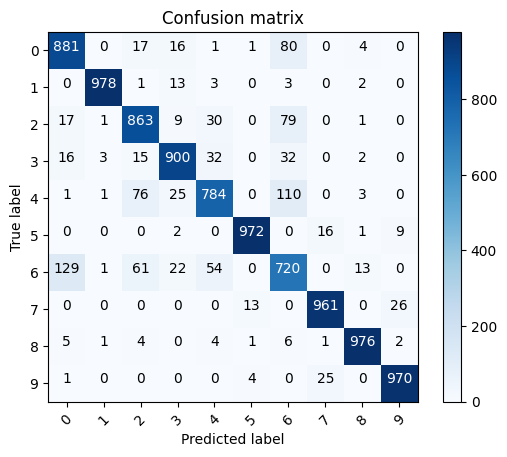

In [ ]:
# get all predictions in an arrat and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # forward pass
  outputs = model(inputs)

  # get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

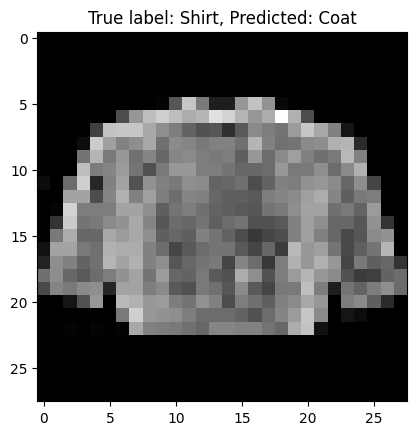

In [ ]:
# Show some miscalssified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.title(f"True label: {labels[y_test[i]]}, Predicted: {labels[p_test[i]]}")
plt.show()
